In [1]:
from typing import List

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from actlearn.select import kriging_believer, predict_posterior

In [2]:
from rdkit.Chem.MolStandardize import rdMolStandardize

params = rdMolStandardize.CleanupParameters()
params.maxTautomers = 100
params.maxTransforms = 100
te = rdMolStandardize.TautomerEnumerator(params)


def inchi_to_smiles(inchi):
    if not inchi:
        return None
    mol = Chem.MolFromInchi(inchi)
    if not mol:
        return None
    return Chem.MolToSmiles(te.Canonicalize(mol))

In [6]:
def rxn_dfp(rsmi):
    r, _, p = rsmi.split('>')
    rfp = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(r), 4, useChirality=True)
    pfp = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(p), 4, useChirality=True)
    return np.array(pfp) - np.array(rfp)

In [8]:
domain = pd.read_csv("../data/brbr_reaction_domain_batch2.csv")
domain.columns

Index(['smiles', 'smiles_alkyl', 'smiles_aryl', 'reaction_smarts',
       'CAD Percent Yield (%)', 'selection', 'category'],
      dtype='object')

In [9]:
domain.shape

(22208, 7)

In [10]:
# make sure product smiels in domain are canonical
domain['smiles'] = domain['smiles'].apply(lambda x: Chem.CanonSmiles(x, False))
domain['smiles_alkyl'] = domain['smiles_alkyl'].apply(lambda x: Chem.CanonSmiles(x, False))
domain['smiles_aryl'] = domain['smiles_aryl'].apply(lambda x: Chem.CanonSmiles(x, False))
# create reaction smiles
domain['rsmi'] = domain.apply(lambda x: f'{x.smiles_alkyl}.{x.smiles_aryl}>>{x["smiles"]}', axis=1)

In [11]:
domain.shape

(22208, 8)

In [12]:
domain.head(5)

,smiles,smiles_alkyl,smiles_aryl,reaction_smarts,CAD Percent Yield (%),selection,category,rsmi
0,CC(C)(C)OC(=O)N1CCC(COc2ccc(CCN(C3OC(=O)c4cccc...,O=C1OC(N(CCBr)C2OC(=O)c3ccccc32)c2ccccc21,CC(C)(C)OC(=O)N1CCC(COc2ccc(Br)cc2)CC1,O=C1O[C@@H](N(CCBr)[C@@H]2OC(=O)c3ccccc32)c2cc...,NaN,NaN,NaN,O=C1OC(N(CCBr)C2OC(=O)c3ccccc32)c2ccccc21.CC(C...
1,CC(C)(C)OC(=O)N1CCN(c2ccc(CCN(C3OC(=O)c4ccccc4...,O=C1OC(N(CCBr)C2OC(=O)c3ccccc32)c2ccccc21,CC(C)(C)OC(=O)N1CCN(c2ccc(Br)cc2Cl)CC1,O=C1O[C@@H](N(CCBr)[C@@H]2OC(=O)c3ccccc32)c2cc...,NaN,NaN,NaN,O=C1OC(N(CCBr)C2OC(=O)c3ccccc32)c2ccccc21.CC(C...
2,CCOC(=O)C(=O)CC(=O)c1ccc(CCN(C2OC(=O)c3ccccc32...,O=C1OC(N(CCBr)C2OC(=O)c3ccccc32)c2ccccc21,CCOC(=O)C(=O)CC(=O)c1ccc(Br)cc1,O=C1O[C@@H](N(CCBr)[C@@H]2OC(=O)c3ccccc32)c2cc...,NaN,NaN,NaN,O=C1OC(N(CCBr)C2OC(=O)c3ccccc32)c2ccccc21.CCOC...
3,O=C1OC(N(CCc2ccc(S(=O)(=O)N3CCSCC3)cc2)C2OC(=O...,O=C1OC(N(CCBr)C2OC(=O)c3ccccc32)c2ccccc21,O=S(=O)(c1ccc(Br)cc1)N1CCSCC1,O=C1O[C@@H](N(CCBr)[C@@H]2OC(=O)c3ccccc32)c2cc...,NaN,NaN,NaN,O=C1OC(N(CCBr)C2OC(=O)c3ccccc32)c2ccccc21.O=S(...
4,CS(=O)(=O)N(c1ccc(CCN(C2OC(=O)c3ccccc32)C2OC(=...,O=C1OC(N(CCBr)C2OC(=O)c3ccccc32)c2ccccc21,CS(=O)(=O)N(c1ccc(Br)cc1)S(C)(=O)=O,O=C1O[C@@H](N(CCBr)[C@@H]2OC(=O)c3ccccc32)c2cc...,NaN,NaN,NaN,O=C1OC(N(CCBr)C2OC(=O)c3ccccc32)c2ccccc21.CS(=...


In [15]:
alkyl = pd.read_csv('../data/BrBr_dft_selectfeatures_alkylBr.csv')
aryl = pd.read_csv('../data/BrBr_dft_selectfeatures_arylBr.csv')
alkyl['smiles'] = alkyl['smiles'].apply(lambda x: Chem.CanonSmiles(x, False))
aryl['core_smiles'] = aryl['core_smiles'].apply(lambda x: Chem.CanonSmiles(x, False))
alkyl = alkyl.groupby('smiles').mean(numeric_only=True)
aryl = aryl.groupby('core_smiles').mean(numeric_only=True)

In [16]:
# add features to domain

domain_dfp = np.vstack(joblib.Parallel(n_jobs=32, verbose=1)(
    joblib.delayed(rxn_dfp)(rsmi) for rsmi in domain['reaction_smarts']
))
domain_core_f = aryl.loc[domain['smiles_aryl']].values
domain_bb_f = alkyl.loc[domain['smiles_alkyl']].values
# merging alkyl and aryl DFT features with reaction fingerprints
domain_f = np.hstack([domain_dfp, domain_core_f, domain_bb_f])
f_cols = [f'f_{idx}' for idx in range(domain_f.shape[1])]
# adding features to domain
domain.loc[:, f_cols] = domain_f

[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:   34.6s
[Parallel(n_jobs=32)]: Done 420 tasks      | elapsed:   35.7s
[Parallel(n_jobs=32)]: Done 1120 tasks      | elapsed:   37.1s
[Parallel(n_jobs=32)]: Done 2408 tasks      | elapsed:   38.9s
[Parallel(n_jobs=32)]: Done 4608 tasks      | elapsed:   41.5s
[Parallel(n_jobs=32)]: Done 7208 tasks      | elapsed:   44.9s
[Parallel(n_jobs=32)]: Done 10208 tasks      | elapsed:   48.7s
[Parallel(n_jobs=32)]: Done 13608 tasks      | elapsed:   53.0s
[Parallel(n_jobs=32)]: Done 17408 tasks      | elapsed:   57.8s
[Parallel(n_jobs=32)]: Done 21608 tasks      | elapsed:  1.1min
[Parallel(n_jobs=32)]: Done 22208 out of 22208 | elapsed:  1.1min finished


In [17]:
domain.shape

(22208, 2143)

In [18]:
task_name = "CAD Percent Yield (%)"
print(domain.shape)
results = domain[(domain[task_name] != 'no signal') & (domain[task_name] != 'INCONCLUSIVE') & (domain[task_name] != 'co eluted')].dropna(subset=[task_name])
print(results.shape)

(22208, 2143)
(161, 2143)


In [19]:
results = results.reset_index(drop=True)
results[task_name] = pd.to_numeric(results[task_name], errors="coerce")
results.dropna(subset=task_name, inplace=True)
print(results.shape)

(159, 2143)


In [20]:
print(domain["category"].value_counts(), domain["selection"].value_counts())

category
test          400
random_52       8
random_28       8
random_44       8
random_12       8
             ... 
random_160      8
random_182      8
random_69       8
random_117      8
random_111      8
Name: count, Length: 200, dtype: int64 selection
active_learning_1    96
initial_diverse      88
Name: count, dtype: int64


In [21]:
# remove anything reserved for test set or already submitted for testing (including example with no data)
domain = domain[(domain["category"] != "test") & (domain["selection"].isna())]

In [22]:
domain.shape

(21624, 2143)

In [23]:
len(domain["smiles"].unique())

21624

In [24]:
results["selection"].value_counts()

selection
initial_diverse      83
active_learning_1    76
Name: count, dtype: int64

In [25]:
results

,smiles,smiles_alkyl,smiles_aryl,reaction_smarts,CAD Percent Yield (%),selection,category,rsmi,f_0,f_1,...,f_2125,f_2126,f_2127,f_2128,f_2129,f_2130,f_2131,f_2132,f_2133,f_2134
0,CC(C)(C)OC(=O)N1CCC(COc2ccc(Cc3ccc(S(=O)(=O)N4...,O=S(=O)(c1ccc(CBr)cc1)N1CCOCC1,CC(C)(C)OC(=O)N1CCC(COc2ccc(Br)cc2)CC1,O=S(=O)(c1ccc(CBr)cc1)N1CCOCC1.CC(C)(C)OC(=O)N...,7.997647,initial_diverse,NaN,O=S(=O)(c1ccc(CBr)cc1)N1CCOCC1.CC(C)(C)OC(=O)N...,0.0,0.0,...,0.1638,0.2128,0.0555,0.0539,0.0546,0.0573,0.1263,0.1238,0.1092,0.1351
1,CC(C)(C)OC(=O)N1CCN(c2ccc(Cc3ccc(S(=O)(=O)N4CC...,O=S(=O)(c1ccc(CBr)cc1)N1CCOCC1,CC(C)(C)OC(=O)N1CCN(c2ccc(Br)cc2Cl)CC1,O=S(=O)(c1ccc(CBr)cc1)N1CCOCC1.CC(C)(C)OC(=O)N...,22.389029,initial_diverse,NaN,O=S(=O)(c1ccc(CBr)cc1)N1CCOCC1.CC(C)(C)OC(=O)N...,0.0,0.0,...,0.1638,0.2128,0.0555,0.0539,0.0546,0.0573,0.1263,0.1238,0.1092,0.1351
2,CCOC(=O)C(=O)CC(=O)c1ccc(Cc2ccc(S(=O)(=O)N3CCO...,O=S(=O)(c1ccc(CBr)cc1)N1CCOCC1,CCOC(=O)C(=O)CC(=O)c1ccc(Br)cc1,O=S(=O)(c1ccc(CBr)cc1)N1CCOCC1.CCOC(=O)C(=O)CC...,0.000000,initial_diverse,NaN,O=S(=O)(c1ccc(CBr)cc1)N1CCOCC1.CCOC(=O)C(=O)CC...,0.0,0.0,...,0.1638,0.2128,0.0555,0.0539,0.0546,0.0573,0.1263,0.1238,0.1092,0.1351
3,O=S(=O)(c1ccc(Cc2ccc(S(=O)(=O)N3CCSCC3)cc2)cc1...,O=S(=O)(c1ccc(CBr)cc1)N1CCOCC1,O=S(=O)(c1ccc(Br)cc1)N1CCSCC1,O=S(=O)(c1ccc(CBr)cc1)N1CCOCC1.O=S(=O)(c1ccc(B...,13.307559,initial_diverse,NaN,O=S(=O)(c1ccc(CBr)cc1)N1CCOCC1.O=S(=O)(c1ccc(B...,0.0,0.0,...,0.1638,0.2128,0.0555,0.0539,0.0546,0.0573,0.1263,0.1238,0.1092,0.1351
4,CS(=O)(=O)N(c1ccc(Cc2ccc(S(=O)(=O)N3CCOCC3)cc2...,O=S(=O)(c1ccc(CBr)cc1)N1CCOCC1,CS(=O)(=O)N(c1ccc(Br)cc1)S(C)(=O)=O,O=S(=O)(c1ccc(CBr)cc1)N1CCOCC1.CS(=O)(=O)N(c1c...,21.440697,initial_diverse,NaN,O=S(=O)(c1ccc(CBr)cc1)N1CCOCC1.CS(=O)(=O)N(c1c...,0.0,0.0,...,0.1638,0.2128,0.0555,0.0539,0.0546,0.0573,0.1263,0.1238,0.1092,0.1351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,CCOC(=O)C(=O)CC(=O)c1ccc(C2CC(F)(F)C2)cc1,FC1(F)CC(Br)C1,CCOC(=O)C(=O)CC(=O)c1ccc(Br)cc1,FC1(F)CC(Br)C1.CCOC(=O)C(=O)CC(=O)c1ccc(Br)cc1...,0.000000,active_learning_1,NaN,FC1(F)CC(Br)C1.CCOC(=O)C(=O)CC(=O)c1ccc(Br)cc1...,0.0,0.0,...,0.3402,0.4295,0.5569,0.5482,0.5672,0.4998,0.4963,0.4737,0.4537,0.4647
157,CS(=O)(=O)N(c1ccc(C2CC(F)(F)C2)cc1)S(C)(=O)=O,FC1(F)CC(Br)C1,CS(=O)(=O)N(c1ccc(Br)cc1)S(C)(=O)=O,FC1(F)CC(Br)C1.CS(=O)(=O)N(c1ccc(Br)cc1)S(C)(=...,0.000000,active_learning_1,NaN,FC1(F)CC(Br)C1.CS(=O)(=O)N(c1ccc(Br)cc1)S(C)(=...,0.0,0.0,...,0.3402,0.4295,0.5569,0.5482,0.5672,0.4998,0.4963,0.4737,0.4537,0.4647
158,Cc1cccc(-c2c(F)cccc2C2CC(F)(F)C2)c1,FC1(F)CC(Br)C1,Cc1cccc(-c2c(F)cccc2Br)c1,FC1(F)CC(Br)C1.Cc1cccc(-c2c(F)cccc2Br)c1>>Cc1c...,0.000000,active_learning_1,NaN,FC1(F)CC(Br)C1.Cc1cccc(-c2c(F)cccc2Br)c1>>Cc1c...,0.0,0.0,...,0.3402,0.4295,0.5569,0.5482,0.5672,0.4998,0.4963,0.4737,0.4537,0.4647
159,COC(=O)c1cc(C2CC(F)(F)C2)ccc1OC(F)F,FC1(F)CC(Br)C1,COC(=O)c1cc(Br)ccc1OC(F)F,FC1(F)CC(Br)C1.COC(=O)c1cc(Br)ccc1OC(F)F>>COC(...,0.000000,active_learning_1,NaN,FC1(F)CC(Br)C1.COC(=O)c1cc(Br)ccc1OC(F)F>>COC(...,0.0,0.0,...,0.3402,0.4295,0.5569,0.5482,0.5672,0.4998,0.4963,0.4737,0.4537,0.4647


In [28]:
experiments = kriging_believer(
    domain=domain,
    results=results,
    x_cols=f_cols,
    batch_size=16,
    id_column='smiles',
    target_column=task_name,
    bb_smiles_column='smiles_alkyl',
    output_dir='iterations/batch_2'
)

  0%|          | 0/16 [00:00<?, ?it/s]/home/rickena1/modules/mcds-actlearn/actlearn/utils.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([df1, df2, df2]).drop_duplicates(subset = columns, keep = False)
  6%|▋         | 1/16 [00:04<01:08,  4.54s/it]/home/rickena1/modules/mcds-actlearn/actlearn/utils.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([df1, df2, df2]).drop_duplicates(subset = columns, keep = False)
 12%|█▎        | 2/16 [00:08<01:02,  4.49s

In [1]:
from rdkit.Chem import PandasTools

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


Failed to patch pandas - unable to change molecule rendering


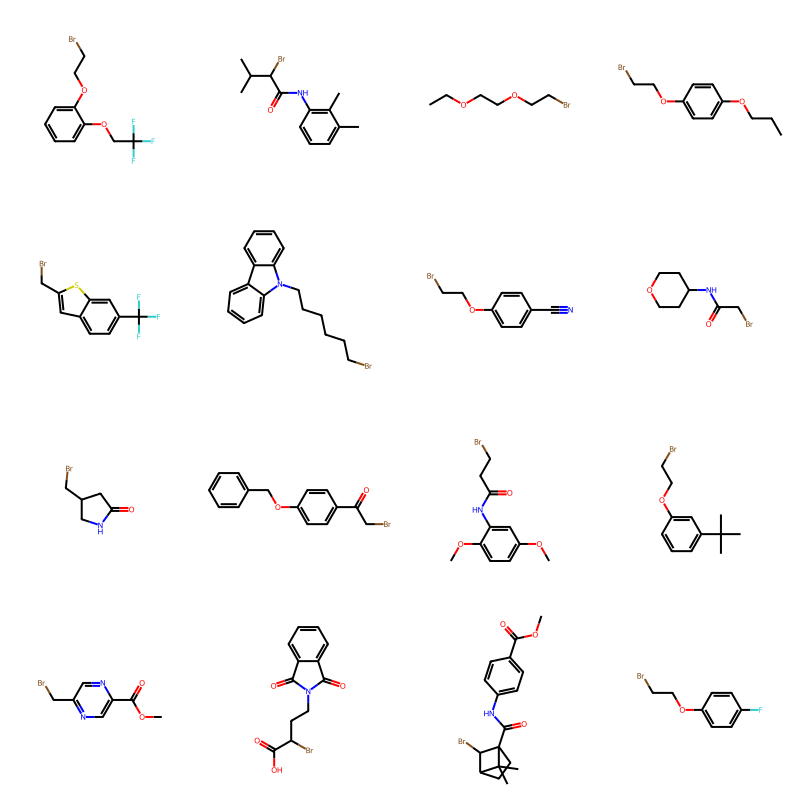

In [9]:
df = PandasTools.LoadSDF('iterations/batch_2/selections.sdf')
Chem.Draw.MolsToGridImage(df["ROMol"], subImgSize=(200,200), molsPerRow=4)

In [7]:
import tarfile

    
with tarfile.open(f'iterations/batch_2.tar.gz', "w:gz") as tar:
    tar.add("iterations/batch_2/")

In [29]:
# In which DFT features are the bromo-ethers chosen here notably different from each other (or other molecules in the dataset)
prop = pd.read_csv("iterations/batch_2/proposed_experiments.csv", index_col=0)

In [30]:
prop

,smiles,smiles_alkyl,smiles_aryl,reaction_smarts,CAD Percent Yield (%),selection,category,rsmi,std
3488,CC(C)(C)OC(=O)N1CCC(COc2ccc(CCOc3ccccc3OCC(F)(...,FC(F)(F)COc1ccccc1OCCBr,CC(C)(C)OC(=O)N1CCC(COc2ccc(Br)cc2)CC1,FC(F)(F)COc1ccccc1OCCBr.CC(C)(C)OC(=O)N1CCC(CO...,42.710697,NaN,NaN,FC(F)(F)COc1ccccc1OCCBr.CC(C)(C)OC(=O)N1CCC(CO...,37.120015
3489,CC(C)(C)OC(=O)N1CCN(c2ccc(CCOc3ccccc3OCC(F)(F)...,FC(F)(F)COc1ccccc1OCCBr,CC(C)(C)OC(=O)N1CCN(c2ccc(Br)cc2Cl)CC1,FC(F)(F)COc1ccccc1OCCBr.CC(C)(C)OC(=O)N1CCN(c2...,49.041149,NaN,NaN,FC(F)(F)COc1ccccc1OCCBr.CC(C)(C)OC(=O)N1CCN(c2...,45.413643
3490,CCOC(=O)C(=O)CC(=O)c1ccc(CCOc2ccccc2OCC(F)(F)F...,FC(F)(F)COc1ccccc1OCCBr,CCOC(=O)C(=O)CC(=O)c1ccc(Br)cc1,FC(F)(F)COc1ccccc1OCCBr.CCOC(=O)C(=O)CC(=O)c1c...,18.759912,NaN,NaN,FC(F)(F)COc1ccccc1OCCBr.CCOC(=O)C(=O)CC(=O)c1c...,33.376498
3491,O=S(=O)(c1ccc(CCOc2ccccc2OCC(F)(F)F)cc1)N1CCSCC1,FC(F)(F)COc1ccccc1OCCBr,O=S(=O)(c1ccc(Br)cc1)N1CCSCC1,FC(F)(F)COc1ccccc1OCCBr.O=S(=O)(c1ccc(Br)cc1)N...,47.460151,NaN,NaN,FC(F)(F)COc1ccccc1OCCBr.O=S(=O)(c1ccc(Br)cc1)N...,44.933165
3492,CS(=O)(=O)N(c1ccc(CCOc2ccccc2OCC(F)(F)F)cc1)S(...,FC(F)(F)COc1ccccc1OCCBr,CS(=O)(=O)N(c1ccc(Br)cc1)S(C)(=O)=O,FC(F)(F)COc1ccccc1OCCBr.CS(=O)(=O)N(c1ccc(Br)c...,31.246906,NaN,NaN,FC(F)(F)COc1ccccc1OCCBr.CS(=O)(=O)N(c1ccc(Br)c...,39.102940
...,...,...,...,...,...,...,...,...,...
14203,O=S(=O)(c1ccc(CCOc2ccc(F)cc2)cc1)N1CCSCC1,Fc1ccc(OCCBr)cc1,O=S(=O)(c1ccc(Br)cc1)N1CCSCC1,Fc1ccc(OCCBr)cc1.O=S(=O)(c1ccc(Br)cc1)N1CCSCC1...,57.260511,NaN,NaN,Fc1ccc(OCCBr)cc1.O=S(=O)(c1ccc(Br)cc1)N1CCSCC1...,37.759906
14204,CS(=O)(=O)N(c1ccc(CCOc2ccc(F)cc2)cc1)S(C)(=O)=O,Fc1ccc(OCCBr)cc1,CS(=O)(=O)N(c1ccc(Br)cc1)S(C)(=O)=O,Fc1ccc(OCCBr)cc1.CS(=O)(=O)N(c1ccc(Br)cc1)S(C)...,10.680784,NaN,NaN,Fc1ccc(OCCBr)cc1.CS(=O)(=O)N(c1ccc(Br)cc1)S(C)...,21.341584
14205,Cc1cccc(-c2c(F)cccc2CCOc2ccc(F)cc2)c1,Fc1ccc(OCCBr)cc1,Cc1cccc(-c2c(F)cccc2Br)c1,Fc1ccc(OCCBr)cc1.Cc1cccc(-c2c(F)cccc2Br)c1>>Cc...,57.489806,NaN,NaN,Fc1ccc(OCCBr)cc1.Cc1cccc(-c2c(F)cccc2Br)c1>>Cc...,18.344158
14206,COC(=O)c1cc(CCOc2ccc(F)cc2)ccc1OC(F)F,Fc1ccc(OCCBr)cc1,COC(=O)c1cc(Br)ccc1OC(F)F,Fc1ccc(OCCBr)cc1.COC(=O)c1cc(Br)ccc1OC(F)F>>CO...,43.894000,NaN,NaN,Fc1ccc(OCCBr)cc1.COC(=O)c1cc(Br)ccc1OC(F)F>>CO...,13.970893


In [42]:
alkyl.loc["BrC(c1ccccc1)(c1ccccc1)c1ccccc1"]

tm_freeh_HOMO(eV)                       -8.709050
tm_freeh_LUMO(eV)                        0.103600
tm_freeh_HLgap(eV)                       8.812650
tm_freeh_HOMO(eV)_alk                   -8.425010
tm_freeh_LUMO(eV)_alk                    1.349900
tm_freeh_HLgap(eV)_alk                   9.774910
tm_freeh_HOMO(eV)_rad                   -6.434430
tm_freeh_LUMO(eV)_rad                   -0.784730
tm_freeh_HLgap(eV)_rad                   5.649700
rad_br                                   0.000000
rad_alk                                  0.002547
C_tm_water_nmr_iso                      82.009866
C_tm_water_charge_mulliken              -0.189510
C_tm_water_charge_loewdin               -0.027550
C_tm_water_charge_paboon                 0.001200
C_tm_water_charge_fasm                   0.000000
C_tm_water_nucleophilic_mulliken        -0.022800
C_tm_water_nucleophilic_loewdin          0.079300
C_tm_water_nucleophilic_paboon           0.138700
C_tm_water_nucleophilic_fasm             0.000000


In [45]:
list(prop["smiles_alkyl"].unique())

['FC(F)(F)COc1ccccc1OCCBr',
 'Cc1cccc(NC(=O)C(Br)C(C)C)c1C',
 'CCOCCOCCBr',
 'CCCOc1ccc(OCCBr)cc1',
 'FC(F)(F)c1ccc2cc(CBr)sc2c1',
 'BrCCCCCCn1c2ccccc2c2ccccc21',
 'N#Cc1ccc(OCCBr)cc1',
 'O=C(CBr)NC1CCOCC1',
 'O=C1CC(CBr)CN1',
 'O=C(CBr)c1ccc(OCc2ccccc2)cc1',
 'COc1ccc(OC)c(NC(=O)CCBr)c1',
 'CC(C)(C)c1cccc(OCCBr)c1',
 'COC(=O)c1cnc(CBr)cn1',
 'O=C(O)C(Br)CCN1C(=O)c2ccccc2C1=O',
 'COC(=O)c1ccc(NC(=O)C23CCC(C2Br)C3(C)C)cc1',
 'Fc1ccc(OCCBr)cc1']

In [47]:
results

,smiles,smiles_alkyl,smiles_aryl,reaction_smarts,CAD Percent Yield (%),selection,category,rsmi,f_0,f_1,...,f_2125,f_2126,f_2127,f_2128,f_2129,f_2130,f_2131,f_2132,f_2133,f_2134
0,CC(C)(C)OC(=O)N1CCC(COc2ccc(Cc3ccc(S(=O)(=O)N4...,O=S(=O)(c1ccc(CBr)cc1)N1CCOCC1,CC(C)(C)OC(=O)N1CCC(COc2ccc(Br)cc2)CC1,O=S(=O)(c1ccc(CBr)cc1)N1CCOCC1.CC(C)(C)OC(=O)N...,7.997647,initial_diverse,NaN,O=S(=O)(c1ccc(CBr)cc1)N1CCOCC1.CC(C)(C)OC(=O)N...,0.0,0.0,...,0.1638,0.2128,0.0555,0.0539,0.0546,0.0573,0.1263,0.1238,0.1092,0.1351
1,CC(C)(C)OC(=O)N1CCN(c2ccc(Cc3ccc(S(=O)(=O)N4CC...,O=S(=O)(c1ccc(CBr)cc1)N1CCOCC1,CC(C)(C)OC(=O)N1CCN(c2ccc(Br)cc2Cl)CC1,O=S(=O)(c1ccc(CBr)cc1)N1CCOCC1.CC(C)(C)OC(=O)N...,22.389029,initial_diverse,NaN,O=S(=O)(c1ccc(CBr)cc1)N1CCOCC1.CC(C)(C)OC(=O)N...,0.0,0.0,...,0.1638,0.2128,0.0555,0.0539,0.0546,0.0573,0.1263,0.1238,0.1092,0.1351
2,CCOC(=O)C(=O)CC(=O)c1ccc(Cc2ccc(S(=O)(=O)N3CCO...,O=S(=O)(c1ccc(CBr)cc1)N1CCOCC1,CCOC(=O)C(=O)CC(=O)c1ccc(Br)cc1,O=S(=O)(c1ccc(CBr)cc1)N1CCOCC1.CCOC(=O)C(=O)CC...,0.000000,initial_diverse,NaN,O=S(=O)(c1ccc(CBr)cc1)N1CCOCC1.CCOC(=O)C(=O)CC...,0.0,0.0,...,0.1638,0.2128,0.0555,0.0539,0.0546,0.0573,0.1263,0.1238,0.1092,0.1351
3,O=S(=O)(c1ccc(Cc2ccc(S(=O)(=O)N3CCSCC3)cc2)cc1...,O=S(=O)(c1ccc(CBr)cc1)N1CCOCC1,O=S(=O)(c1ccc(Br)cc1)N1CCSCC1,O=S(=O)(c1ccc(CBr)cc1)N1CCOCC1.O=S(=O)(c1ccc(B...,13.307559,initial_diverse,NaN,O=S(=O)(c1ccc(CBr)cc1)N1CCOCC1.O=S(=O)(c1ccc(B...,0.0,0.0,...,0.1638,0.2128,0.0555,0.0539,0.0546,0.0573,0.1263,0.1238,0.1092,0.1351
4,CS(=O)(=O)N(c1ccc(Cc2ccc(S(=O)(=O)N3CCOCC3)cc2...,O=S(=O)(c1ccc(CBr)cc1)N1CCOCC1,CS(=O)(=O)N(c1ccc(Br)cc1)S(C)(=O)=O,O=S(=O)(c1ccc(CBr)cc1)N1CCOCC1.CS(=O)(=O)N(c1c...,21.440697,initial_diverse,NaN,O=S(=O)(c1ccc(CBr)cc1)N1CCOCC1.CS(=O)(=O)N(c1c...,0.0,0.0,...,0.1638,0.2128,0.0555,0.0539,0.0546,0.0573,0.1263,0.1238,0.1092,0.1351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,CCOC(=O)C(=O)CC(=O)c1ccc(C2CC(F)(F)C2)cc1,FC1(F)CC(Br)C1,CCOC(=O)C(=O)CC(=O)c1ccc(Br)cc1,FC1(F)CC(Br)C1.CCOC(=O)C(=O)CC(=O)c1ccc(Br)cc1...,0.000000,active_learning_1,NaN,FC1(F)CC(Br)C1.CCOC(=O)C(=O)CC(=O)c1ccc(Br)cc1...,0.0,0.0,...,0.3402,0.4295,0.5569,0.5482,0.5672,0.4998,0.4963,0.4737,0.4537,0.4647
157,CS(=O)(=O)N(c1ccc(C2CC(F)(F)C2)cc1)S(C)(=O)=O,FC1(F)CC(Br)C1,CS(=O)(=O)N(c1ccc(Br)cc1)S(C)(=O)=O,FC1(F)CC(Br)C1.CS(=O)(=O)N(c1ccc(Br)cc1)S(C)(=...,0.000000,active_learning_1,NaN,FC1(F)CC(Br)C1.CS(=O)(=O)N(c1ccc(Br)cc1)S(C)(=...,0.0,0.0,...,0.3402,0.4295,0.5569,0.5482,0.5672,0.4998,0.4963,0.4737,0.4537,0.4647
158,Cc1cccc(-c2c(F)cccc2C2CC(F)(F)C2)c1,FC1(F)CC(Br)C1,Cc1cccc(-c2c(F)cccc2Br)c1,FC1(F)CC(Br)C1.Cc1cccc(-c2c(F)cccc2Br)c1>>Cc1c...,0.000000,active_learning_1,NaN,FC1(F)CC(Br)C1.Cc1cccc(-c2c(F)cccc2Br)c1>>Cc1c...,0.0,0.0,...,0.3402,0.4295,0.5569,0.5482,0.5672,0.4998,0.4963,0.4737,0.4537,0.4647
159,COC(=O)c1cc(C2CC(F)(F)C2)ccc1OC(F)F,FC1(F)CC(Br)C1,COC(=O)c1cc(Br)ccc1OC(F)F,FC1(F)CC(Br)C1.COC(=O)c1cc(Br)ccc1OC(F)F>>COC(...,0.000000,active_learning_1,NaN,FC1(F)CC(Br)C1.COC(=O)c1cc(Br)ccc1OC(F)F>>COC(...,0.0,0.0,...,0.3402,0.4295,0.5569,0.5482,0.5672,0.4998,0.4963,0.4737,0.4537,0.4647


In [48]:
alkyl_exp = alkyl.loc[list(results["smiles_alkyl"].unique())]
alkyl_exp

,tm_freeh_HOMO(eV),tm_freeh_LUMO(eV),tm_freeh_HLgap(eV),tm_freeh_HOMO(eV)_alk,tm_freeh_LUMO(eV)_alk,tm_freeh_HLgap(eV)_alk,tm_freeh_HOMO(eV)_rad,tm_freeh_LUMO(eV)_rad,tm_freeh_HLgap(eV)_rad,rad_br,...,Br_tm_water_nucleophilic_paboon,Br_tm_water_nucleophilic_fasm,Br_tm_water_electrophilic_mulliken,Br_tm_water_electrophilic_loewdin,Br_tm_water_electrophilic_paboon,Br_tm_water_electrophilic_fasm,Br_tm_water_radical_mulliken,Br_tm_water_radical_loewdin,Br_tm_water_radical_paboon,Br_tm_water_radical_fasm
smiles,,,,,,,,,,,,,,,,,,,,,
O=S(=O)(c1ccc(CBr)cc1)N1CCOCC1,-8.69393,-0.16277,8.53116,-8.55647,0.56444,9.12090,-7.72252,-1.28813,6.43439,0.024041,...,0.1638,0.2128,0.0555,0.0539,0.0546,0.0573,0.1263,0.1238,0.1092,0.1351
CC(C)(C)OC(=O)N1CCCC(CBr)C1,-8.70383,1.80663,10.51046,-8.48650,3.15677,11.64327,-7.84647,0.55491,8.40138,0.047924,...,0.2859,0.3502,0.1213,0.1143,0.1175,0.1224,0.2442,0.2313,0.2017,0.2363
COc1ccc2c(CBr)cc(=O)oc2c1,-8.23929,-0.53271,7.70659,-8.06036,0.00414,8.06451,-8.02587,-1.51615,6.50973,0.022402,...,0.1342,0.1708,0.0558,0.0492,0.0497,0.0694,0.1056,0.0998,0.0919,0.1201
COc1cc(C=O)ccc1OCCBr,-8.13774,0.14331,8.28105,-7.91786,0.31024,8.22810,-7.96162,0.16890,8.13052,0.046255,...,0.0120,0.0178,0.0286,0.0248,0.0246,0.0331,0.0215,0.0184,0.0183,0.0254
FC(F)(F)c1cccc(OCCBr)c1,-8.79204,0.65513,9.44717,-8.49642,0.87998,9.37640,-8.40660,-0.08439,8.32221,0.044488,...,0.0721,0.1195,0.1329,0.1235,0.1264,0.1328,0.1231,0.1148,0.0992,0.1262
OB(O)c1ccc(OCCBr)cc1,-8.33521,1.13982,9.47503,-8.04392,1.38359,9.42751,-8.06275,0.12281,8.18556,0.045214,...,0.1021,0.1553,0.0931,0.0844,0.0860,0.0951,0.1213,0.1130,0.0940,0.1252
C[Si](C)(C)N(CCCBr)[Si](C)(C)C,-8.17276,1.93010,10.10286,-8.03176,3.06496,11.09672,-7.68825,0.72295,8.41119,0.047474,...,0.3193,0.4215,0.0764,0.0722,0.0715,0.0898,0.2477,0.2350,0.1954,0.2557
COc1ccc(F)cc1C(=O)CBr,-8.52986,-0.35718,8.17268,-8.40537,0.08859,8.49396,-8.34341,-1.37797,6.96543,0.031352,...,0.1207,0.1668,0.1010,0.0933,0.0947,0.1192,0.1225,0.1162,0.1077,0.1430
Cc1nc(C)c2c(n1)OC(CBr)C2,-8.84415,0.93592,9.78007,-8.59383,1.13863,9.73246,-8.41609,-0.11083,8.30525,0.047594,...,0.0715,0.1181,0.1132,0.1064,0.1083,0.1164,0.1105,0.1051,0.0899,0.1173


In [46]:
# which features in alkyl are farthest from the experimental data (relative to mean and std)
alkyl_sel = alkyl.loc[list(prop["smiles_alkyl"].unique())]
alkyl_sel

,tm_freeh_HOMO(eV),tm_freeh_LUMO(eV),tm_freeh_HLgap(eV),tm_freeh_HOMO(eV)_alk,tm_freeh_LUMO(eV)_alk,tm_freeh_HLgap(eV)_alk,tm_freeh_HOMO(eV)_rad,tm_freeh_LUMO(eV)_rad,tm_freeh_HLgap(eV)_rad,rad_br,...,Br_tm_water_nucleophilic_paboon,Br_tm_water_nucleophilic_fasm,Br_tm_water_electrophilic_mulliken,Br_tm_water_electrophilic_loewdin,Br_tm_water_electrophilic_paboon,Br_tm_water_electrophilic_fasm,Br_tm_water_radical_mulliken,Br_tm_water_radical_loewdin,Br_tm_water_radical_paboon,Br_tm_water_radical_fasm
smiles,,,,,,,,,,,,,,,,,,,,,
FC(F)(F)COc1ccccc1OCCBr,-8.31276,1.40957,9.72233,-8.14706,1.58089,9.72795,-8.19745,0.09095,8.28841,0.045427,...,0.1359,0.2020,0.0594,0.0541,0.0536,0.0794,0.1258,0.1206,0.0948,0.1407
Cc1cccc(NC(=O)C(Br)C(C)C)c1C,-8.09330,1.15436,9.24766,-7.94954,1.39116,9.34071,-7.64566,-0.97021,6.67546,0.035022,...,0.0877,0.1288,0.0517,0.0428,0.0394,0.0646,0.0870,0.0761,0.0635,0.0967
CCOCCOCCBr,-9.22642,2.28009,11.50651,-8.89372,3.56323,12.45695,-7.92362,0.52941,8.45303,0.049329,...,0.3724,0.4653,0.1916,0.1805,0.1840,0.1976,0.3302,0.3166,0.2782,0.3315
CCCOc1ccc(OCCBr)cc1,-7.63854,1.40021,9.03875,-7.37055,1.65468,9.02524,-7.39145,0.24844,7.63989,0.045610,...,0.1344,0.1986,0.0481,0.0404,0.0402,0.0524,0.1197,0.1116,0.0873,0.1255
FC(F)(F)c1ccc2cc(CBr)sc2c1,-8.57646,-0.33367,8.24279,-8.30652,0.33462,8.64114,-7.40276,-1.36268,6.04008,0.017751,...,0.1548,0.1938,0.0922,0.0856,0.0870,0.1038,0.1375,0.1329,0.1209,0.1488
BrCCCCCCn1c2ccccc2c2ccccc21,-7.49472,0.73373,8.22845,-7.42479,0.79926,8.22405,-7.44166,0.77921,8.22087,0.047080,...,0.0014,0.0019,0.0025,0.0020,0.0022,0.0038,0.0019,0.0015,0.0018,0.0029
N#Cc1ccc(OCCBr)cc1,-8.77826,0.36266,9.14092,-8.50257,0.59281,9.09538,-8.50688,-0.27166,8.23522,0.044167,...,0.0479,0.0799,0.1173,0.1093,0.1122,0.1170,0.0964,0.0892,0.0800,0.0985
O=C(CBr)NC1CCOCC1,-9.28023,1.65528,10.93551,-8.95619,2.81817,11.77436,-8.85267,-0.98895,7.86372,0.038826,...,0.3242,0.4344,0.1488,0.1426,0.1446,0.1498,0.2789,0.2715,0.2344,0.2921
O=C1CC(CBr)CN1,-9.04838,1.67999,10.72837,-8.77308,2.95653,11.72962,-8.04321,0.31287,8.35609,0.047918,...,0.2921,0.3785,0.2349,0.2318,0.2388,0.2253,0.3048,0.2933,0.2655,0.3019


In [77]:
alkyl_sel["Br_tm_water_nmr_iso"]

smiles
FC(F)(F)COc1ccccc1OCCBr                      2364.809144
Cc1cccc(NC(=O)C(Br)C(C)C)c1C                 2368.187047
CCOCCOCCBr                                   2417.069757
CCCOc1ccc(OCCBr)cc1                          2425.321206
FC(F)(F)c1ccc2cc(CBr)sc2c1                   2063.520823
BrCCCCCCn1c2ccccc2c2ccccc21                  2385.211258
N#Cc1ccc(OCCBr)cc1                           2412.417169
O=C(CBr)NC1CCOCC1                            2380.628133
O=C1CC(CBr)CN1                               2358.828923
O=C(CBr)c1ccc(OCc2ccccc2)cc1                 2446.871387
COc1ccc(OC)c(NC(=O)CCBr)c1                   2366.410174
CC(C)(C)c1cccc(OCCBr)c1                      2424.229163
COC(=O)c1cnc(CBr)cn1                         2114.192723
O=C(O)C(Br)CCN1C(=O)c2ccccc2C1=O             1956.221069
COC(=O)c1ccc(NC(=O)C23CCC(C2Br)C3(C)C)cc1    2357.466692
Fc1ccc(OCCBr)cc1                             2422.789791
Name: Br_tm_water_nmr_iso, dtype: float64

* Calculate mean and standard deviation for each column (from full alkyl dataframe)
* Find minimum difference between each proposed molecule and a value in 

In [49]:
from sklearn import ensemble
from sklearn.inspection import permutation_importance

In [50]:
# RF feature importance
train_X = results[f_cols]
train_y = results[task_name]
train_X

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_2125,f_2126,f_2127,f_2128,f_2129,f_2130,f_2131,f_2132,f_2133,f_2134
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.1638,0.2128,0.0555,0.0539,0.0546,0.0573,0.1263,0.1238,0.1092,0.1351
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.1638,0.2128,0.0555,0.0539,0.0546,0.0573,0.1263,0.1238,0.1092,0.1351
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.1638,0.2128,0.0555,0.0539,0.0546,0.0573,0.1263,0.1238,0.1092,0.1351
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.1638,0.2128,0.0555,0.0539,0.0546,0.0573,0.1263,0.1238,0.1092,0.1351
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.1638,0.2128,0.0555,0.0539,0.0546,0.0573,0.1263,0.1238,0.1092,0.1351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.3402,0.4295,0.5569,0.5482,0.5672,0.4998,0.4963,0.4737,0.4537,0.4647
157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.3402,0.4295,0.5569,0.5482,0.5672,0.4998,0.4963,0.4737,0.4537,0.4647
158,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.3402,0.4295,0.5569,0.5482,0.5672,0.4998,0.4963,0.4737,0.4537,0.4647
159,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.3402,0.4295,0.5569,0.5482,0.5672,0.4998,0.4963,0.4737,0.4537,0.4647


In [51]:
model = RandomForestRegressor(n_jobs=-1, n_estimators=500, random_state=42)
model.fit(train_X, train_y)

RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=42)

In [52]:
feature_importance = permutation_importance(
    model, train_X, train_y, n_repeats=10, random_state=42, n_jobs=-1
)

In [53]:
feature_importance

{'importances_mean': array([0.00036816, 0.        , 0.00012912, ..., 0.00082797, 0.00417821,
        0.00082788]),
 'importances_std': array([7.13511789e-05, 0.00000000e+00, 2.30155067e-05, ...,
        1.79883253e-04, 9.44788522e-04, 1.89747054e-04]),
 'importances': array([[3.34312851e-04, 3.13693814e-04, 4.96881577e-04, ...,
         3.36943970e-04, 3.23706198e-04, 3.37829681e-04],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.20080654e-04, 1.31142530e-04, 1.70046530e-04, ...,
         8.94706911e-05, 1.16736178e-04, 1.48394408e-04],
        ...,
        [1.02120533e-03, 8.64380410e-04, 8.07244840e-04, ...,
         7.79161056e-04, 6.92230764e-04, 4.99297575e-04],
        [4.68752436e-03, 3.34312640e-03, 2.42346167e-03, ...,
         4.78146080e-03, 4.62907481e-03, 4.73344959e-03],
        [8.14094322e-04, 4.49062823e-04, 7.40372279e-04, ...,
         9.10341977e-04, 7.79161546e-04, 1.04827945e-03]]

In [54]:
fimp_ser = pd.Series(feature_importance.importances_mean, index=f_cols)

In [57]:
fimp_ser.sort_values(ascending=False).head(10)

f_2118    0.751954
f_2053    0.086373
f_1656    0.035553
f_841     0.028968
f_2051    0.014913
f_2048    0.012721
f_2111    0.011610
f_2099    0.010579
f_550     0.009974
f_2057    0.009522
dtype: float64

In [70]:
ar_col = list(aryl.columns)
alk_col = list(alkyl.columns)
print(alk_col[2118 - 2048 - 42])
print(ar_col[2053 - 2048])
print()
print()
print(ar_col[2051 - 2048])
print(ar_col[0])
print(alk_col[2111 - 2048 - 42])
print(alk_col[2099 - 2048 - 42])
print()
print(ar_col[2057 - 2048])

Br_tm_water_nmr_iso
core_tm_freeh_HOMO(eV)


core_tm_water_electronegativity [eV]
core_tm_water_ionization_potential [eV]
C_tm_water_electrophilic_loewdin
rad_br

core_C_tm_water_charge_mulliken


In [71]:
domain["f_2118"]

0        2368.363815
1        2368.363815
2        2368.363815
3        2368.363815
4        2368.363815
            ...     
22203    2530.434365
22204    2530.434365
22205    2530.434365
22206    2530.434365
22207    2530.434365
Name: f_2118, Length: 21624, dtype: float64

In [72]:
alkyl["Br_tm_water_nmr_iso"]

smiles
BrC(c1ccccc1)(c1ccccc1)c1ccccc1     1391.305852
BrC(c1ccccc1)c1ccccc1               1830.429050
BrC(c1ccccc1)c1ccccn1               1866.060290
BrC1(c2ccccc2)c2ccccc2-c2ccccc21    1672.950762
BrC1(c2ccccn2)CC1                   2135.347006
                                       ...     
Oc1ccc2ccc(OCCCCBr)cc2n1            2387.348005
Oc1cccc(CBr)c1                      2115.344031
Oc1cccc(CCBr)c1                     2384.237076
Oc1ccccc1CCBr                       2385.080724
SCCCBr                              2417.363824
Name: Br_tm_water_nmr_iso, Length: 2776, dtype: float64

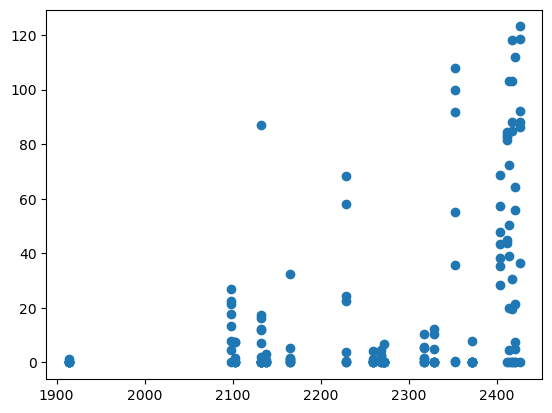

In [74]:
plt.scatter(results["f_2118"], results["CAD Percent Yield (%)"])

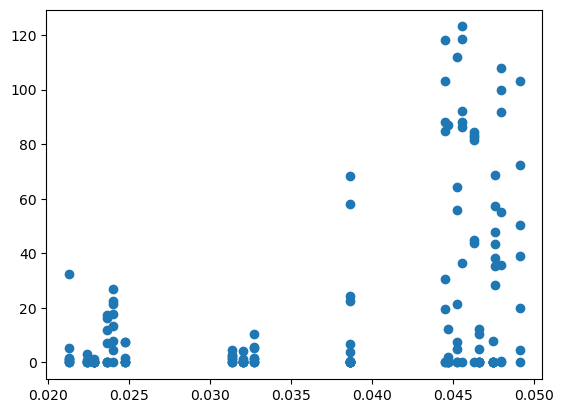

In [75]:
plt.scatter(results["f_2099"], results["CAD Percent Yield (%)"])

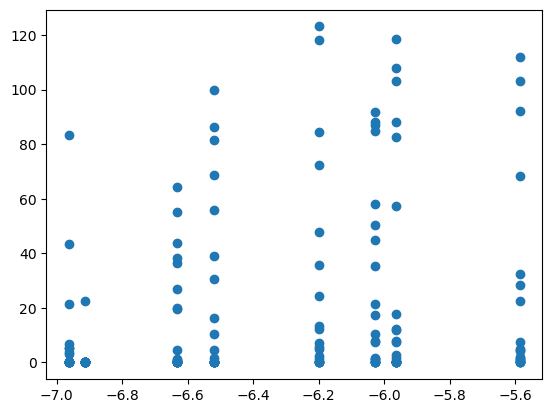

In [76]:
plt.scatter(results["f_2053"], results["CAD Percent Yield (%)"])